In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Define

In [3]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Những segment có F1 > 0.5 thì coi như detect được

In [58]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,anomaly_idx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    anomaly = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    anomaly[anomaly_idx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(anomaly, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(anomaly, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(anomaly, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(anomaly, pred))
    
    accuracy = (tp + tn) / len(anomaly)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    result ={'Metrics':['Accuracy' ,'Precision','Recall','F1-score' ],
             'Score':[accuracy,precision, recall, f1]}
    result = pd.DataFrame(result)
    display(result.T)
    return accuracy,precision,recall,f1

# Data

In [5]:
num_datapoints = 8640
time_index = pd.date_range(start='2024-01-01', periods=num_datapoints, freq='s')

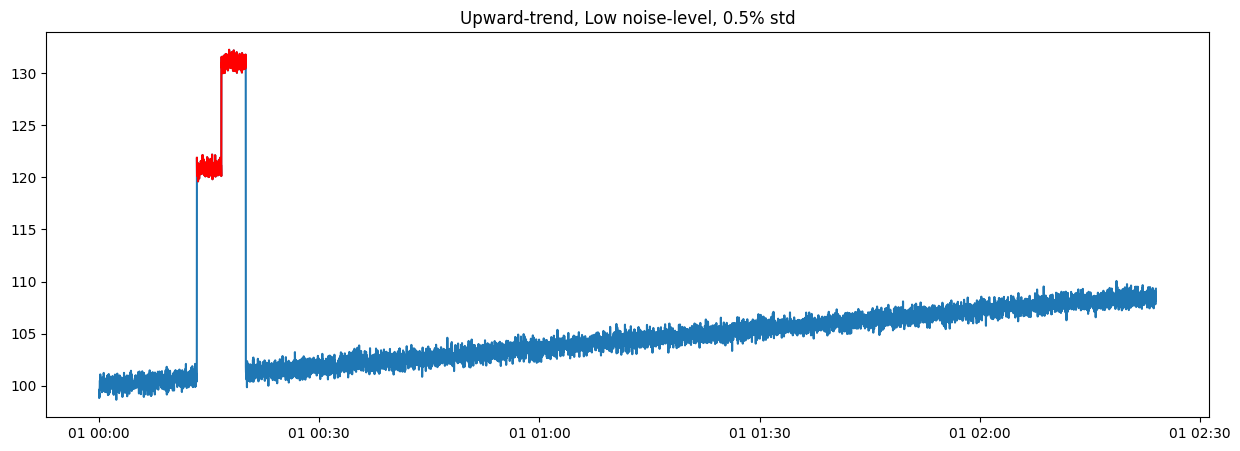

In [7]:
mean_traffic = 100  
std_dev_traffic = 0.5

start_noise_period = 800  
end_noise_period = 1200   
noise_level = 20 


noise = np.zeros(num_datapoints)
noise[start_noise_period:end_noise_period] = np.full(400,noise_level)
noise[start_noise_period+200:end_noise_period] = np.full(200,noise_level*1.5)

traffic_data = np.random.normal(loc=mean_traffic, scale=std_dev_traffic, size=num_datapoints)
traffic_data_with_noise = traffic_data + noise
traffic_data_with_noise = traffic_data_with_noise + np.arange(num_datapoints)*0.001

network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data_with_noise},index=time_index)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(network_traffic_df)
ax.plot(network_traffic_df[start_noise_period:end_noise_period],c='r')
ax.set_title('Upward-trend, Low noise-level, 0.5% std');


In [8]:
anomaly_idx = list(np.arange(start_noise_period,end_noise_period))

# Feature

In [9]:
ts = pd.DataFrame(network_traffic_df['Traffic_Mbps'])
ts['id'] = 1

In [10]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_value='Traffic_Mbps')

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.61s/it]


In [48]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=['Traffic_Mbps__mean',
                                                                     'Traffic_Mbps__median',
                                                                     'Traffic_Mbps__variance',
                                                                     'Traffic_Mbps__standard_deviation',
                                                                     'Traffic_Mbps__absolute_sum_of_changes',
                                                                     'Traffic_Mbps__mean_abs_change',
                                                                     'Traffic_Mbps__kurtosis',
                                                                     'Traffic_Mbps__minimum',
                                                                     'Traffic_Mbps__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: 'Traffic_Mbps'})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','absolute_sum_of_changes','mean_abs_change',
                                      'kurtosis','minimum','maximum']

In [49]:
extracted_relevant_feature

,Traffic_Mbps
mean,105.479853
median,104.740898
variance,27.596187
standard_deviation,5.253207
absolute_sum_of_changes,4896.920656
mean_abs_change,0.566839
kurtosis,11.940497
minimum,98.632061
maximum,132.271730


# Top-down

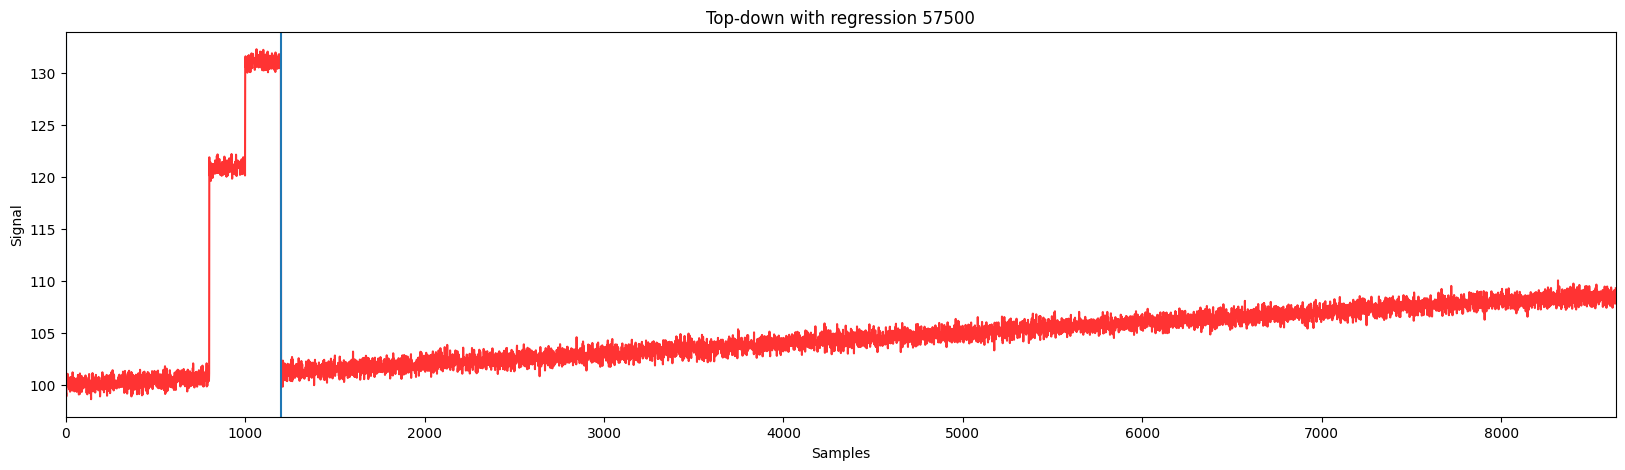

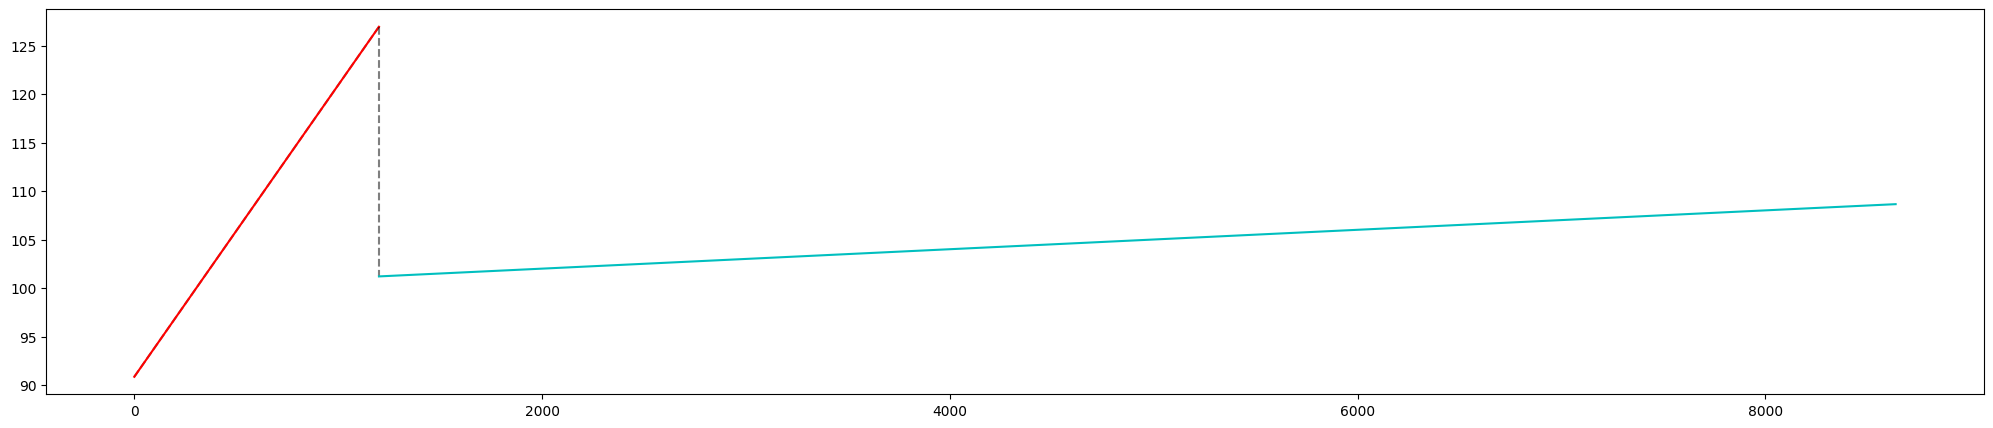

In [26]:
max_error = 57500
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

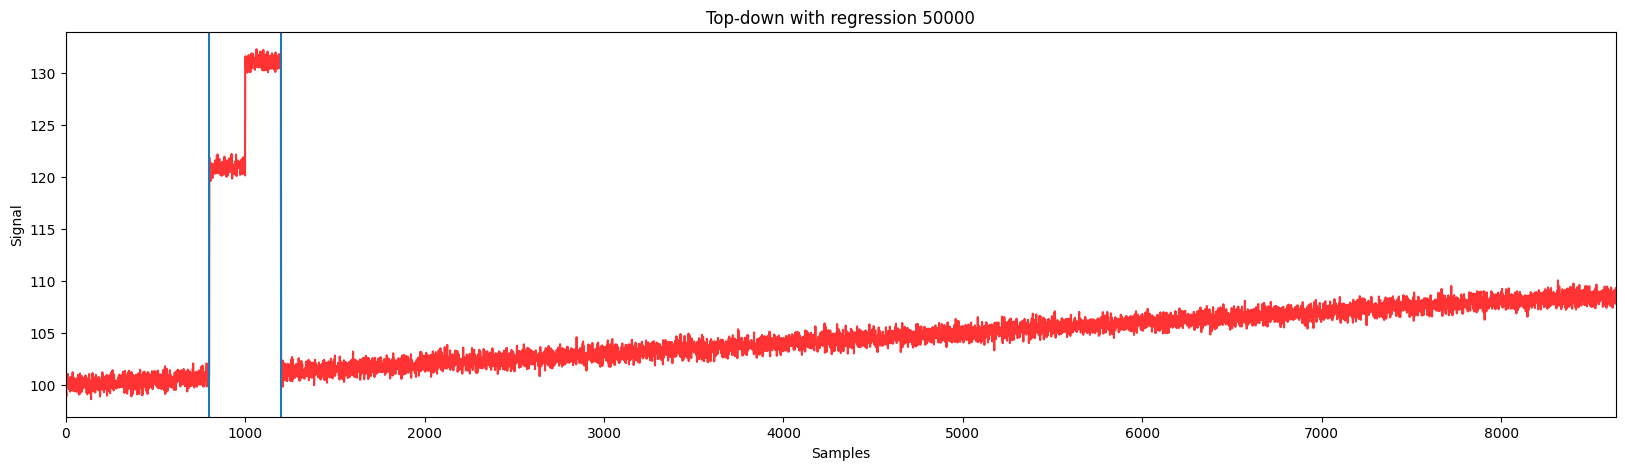

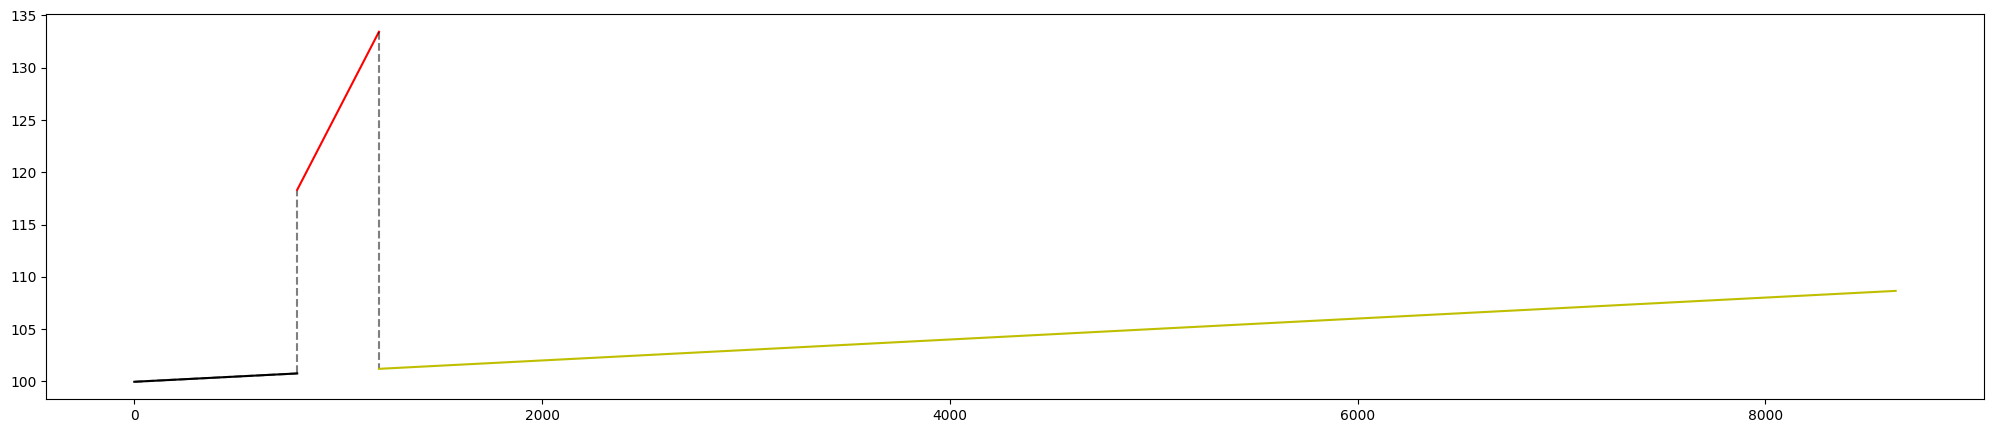

In [20]:
max_error = 50000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

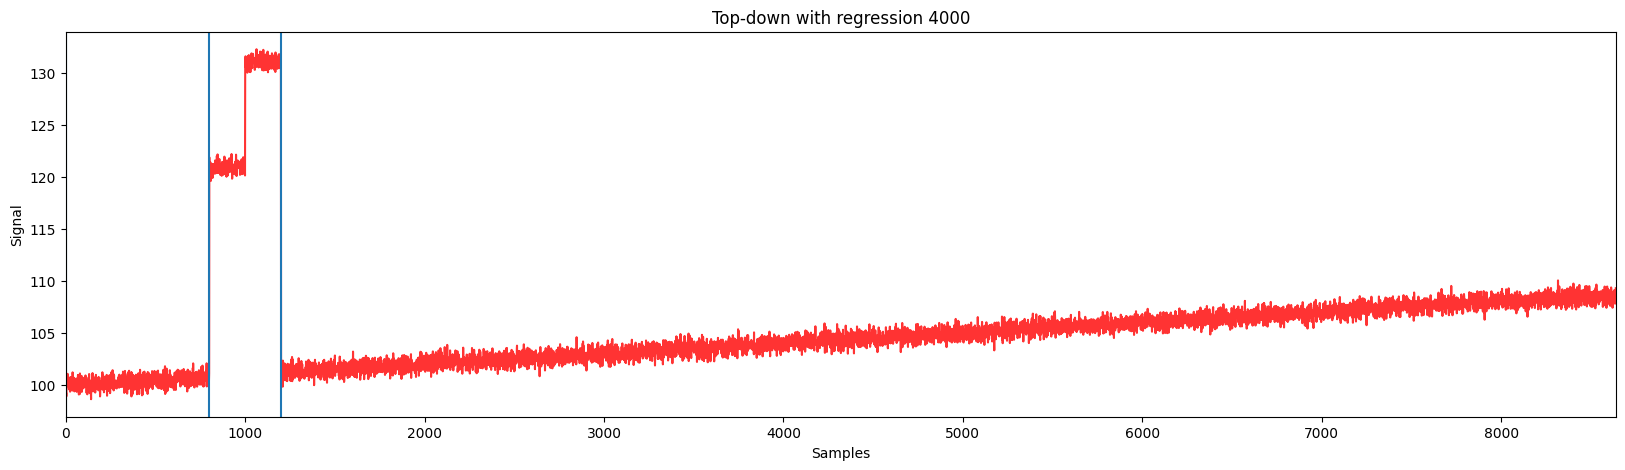

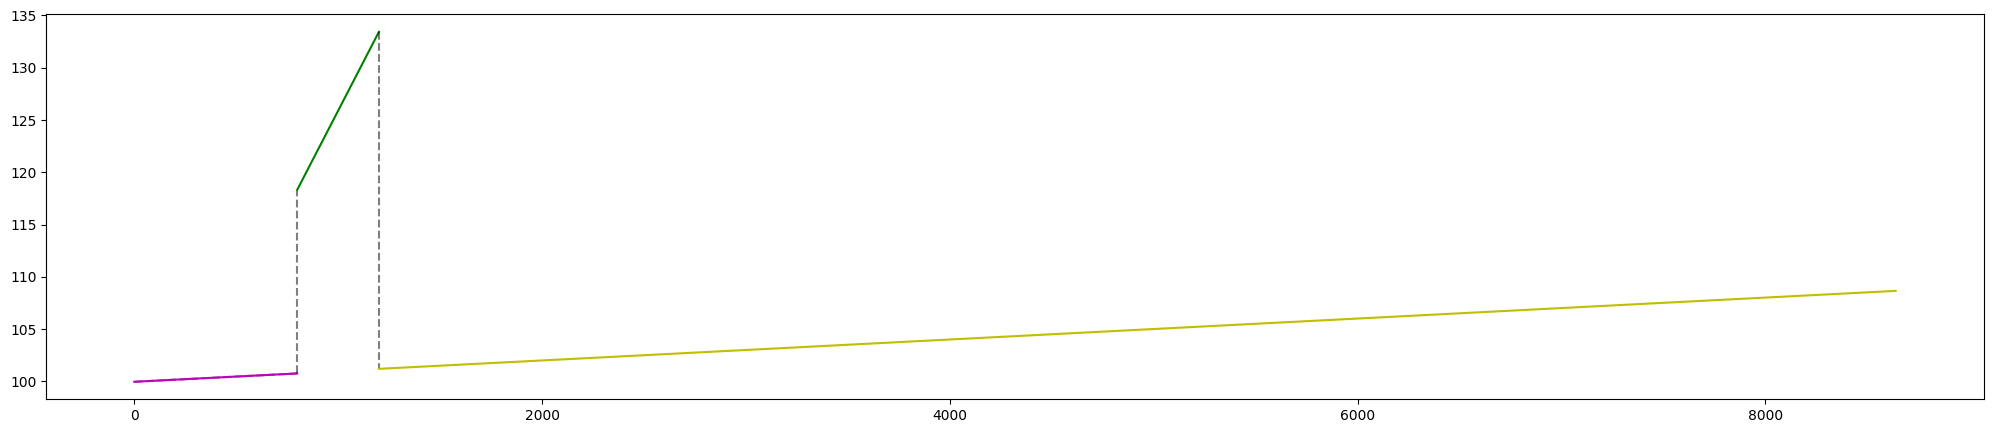

In [34]:
max_error = 4000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [25]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

,Metrics,Score
0,Accuracy,0.999884
1,Precision,0.997506
2,Recall,1.000000
3,F1-score,0.998752


In [38]:
range_max_error_topdown = (4000,57500)
best_Top_down = 29500
time_avg_Top_down = (12.2+11.4+10.9)/3

# Bottom-up

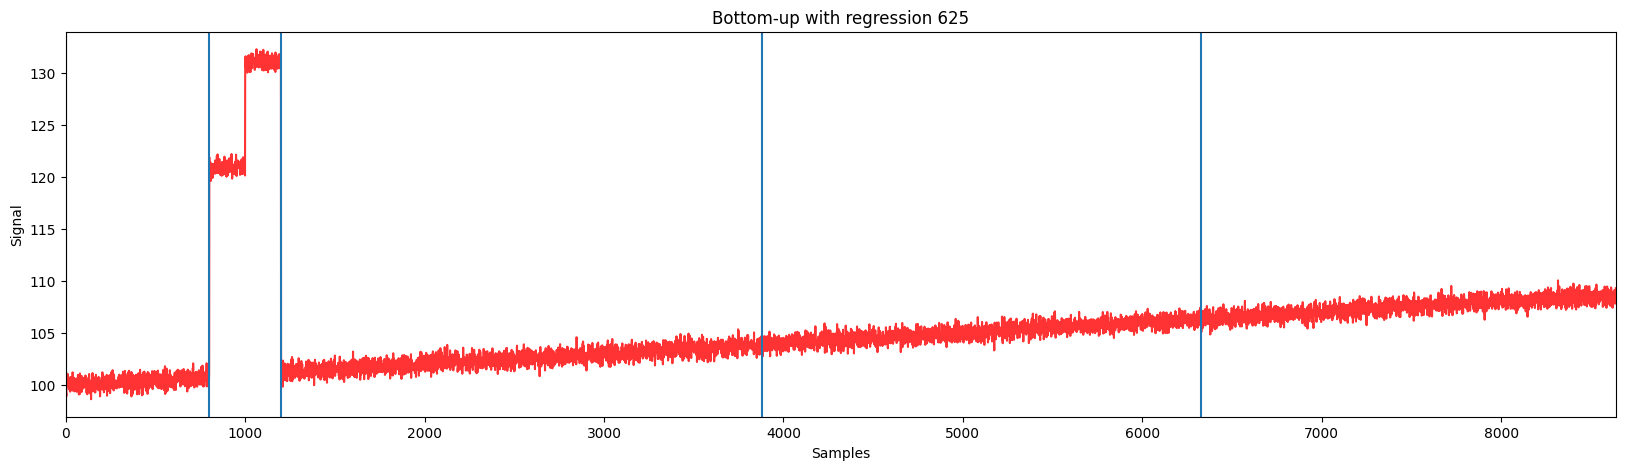

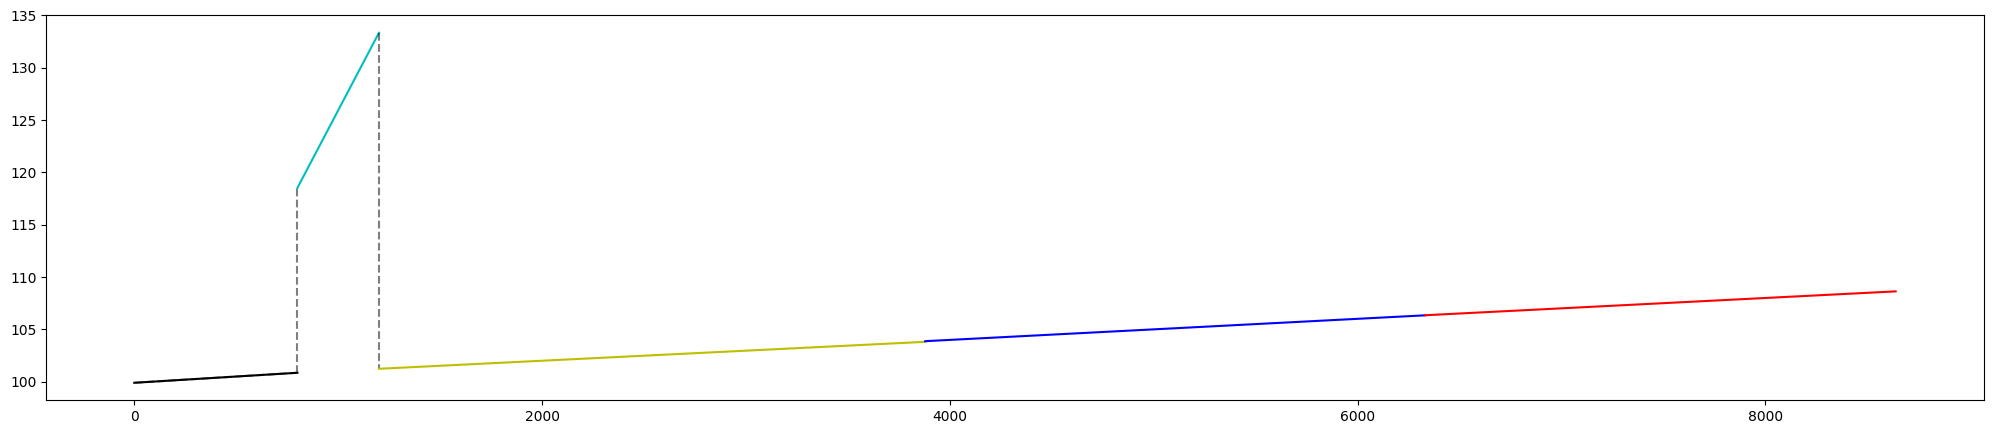

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [66]:
max_error = 625
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

## Best

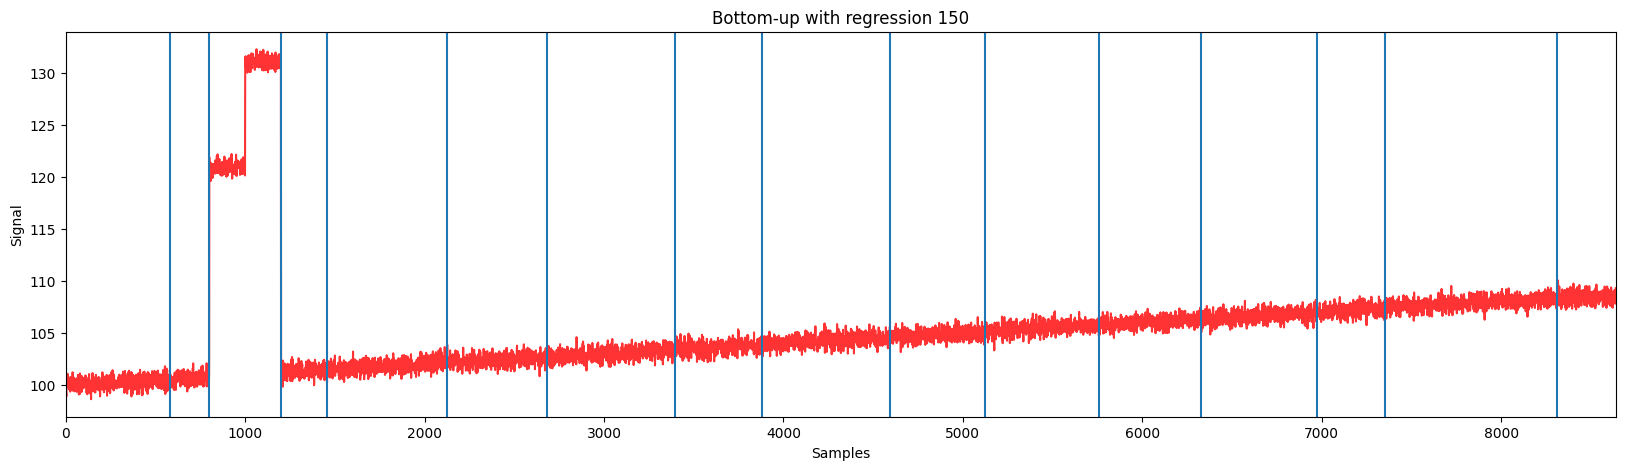

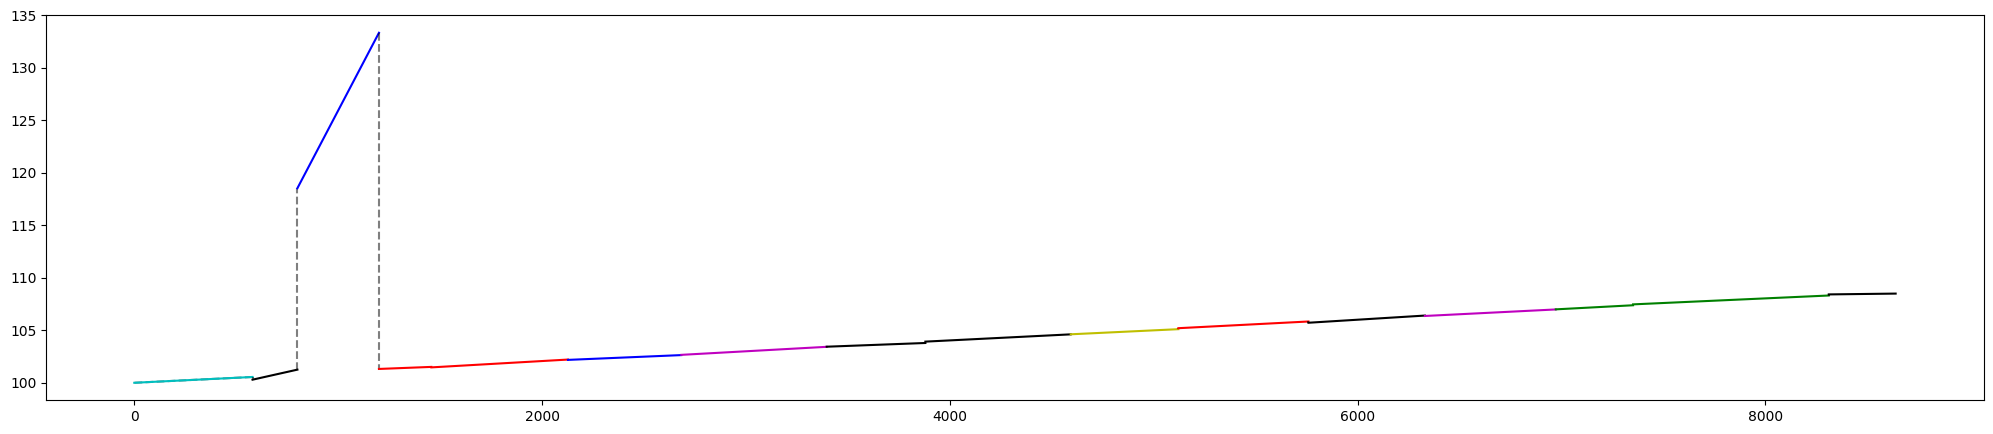

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [94]:
max_error = 150
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

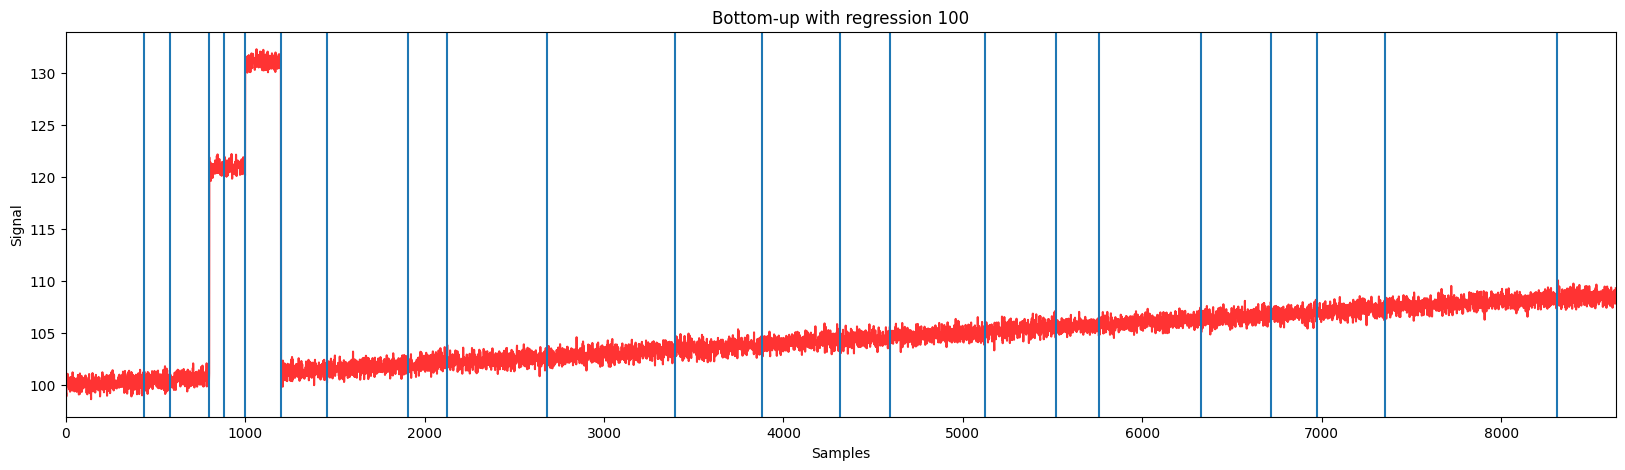

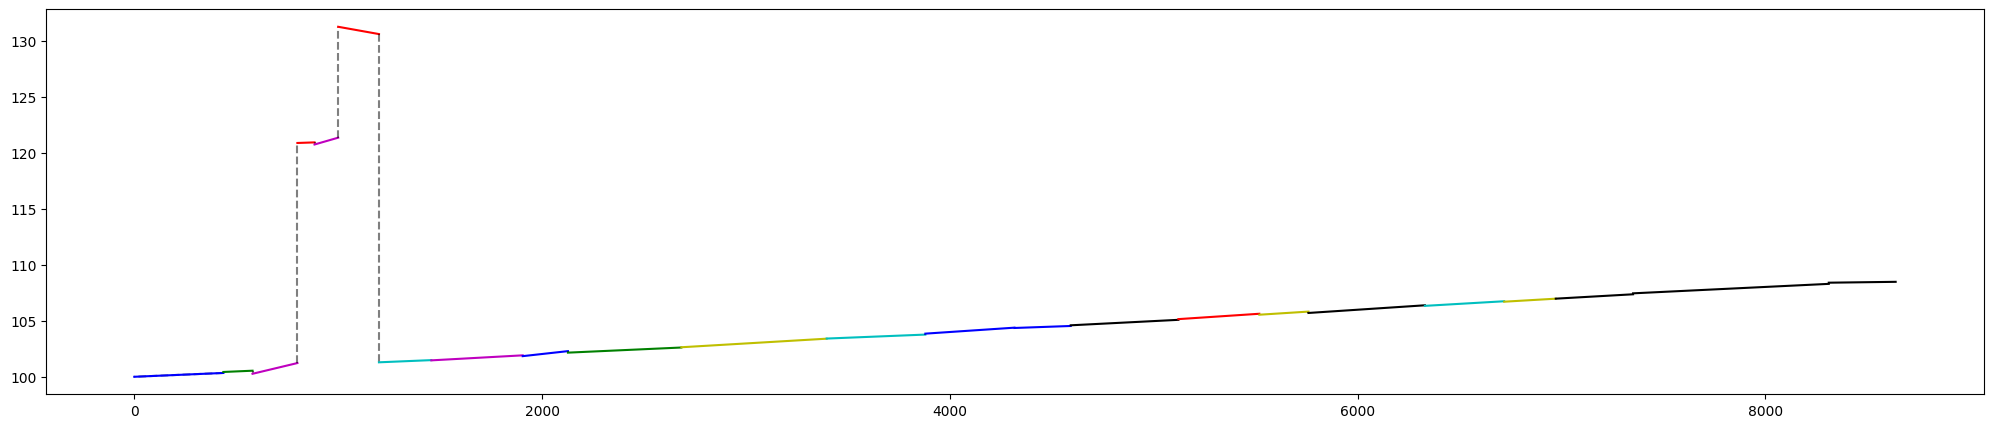

,Metrics,Score
0,Accuracy,0.976852
1,Precision,1.000000
2,Recall,0.500000
3,F1-score,0.666667


In [57]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [67]:
range_max_error_bottomup = (100,625)
best_Bottom_up = 350
time_avg_Bottom_up = (5.29+5.32+5.30)/3

# Sliding window

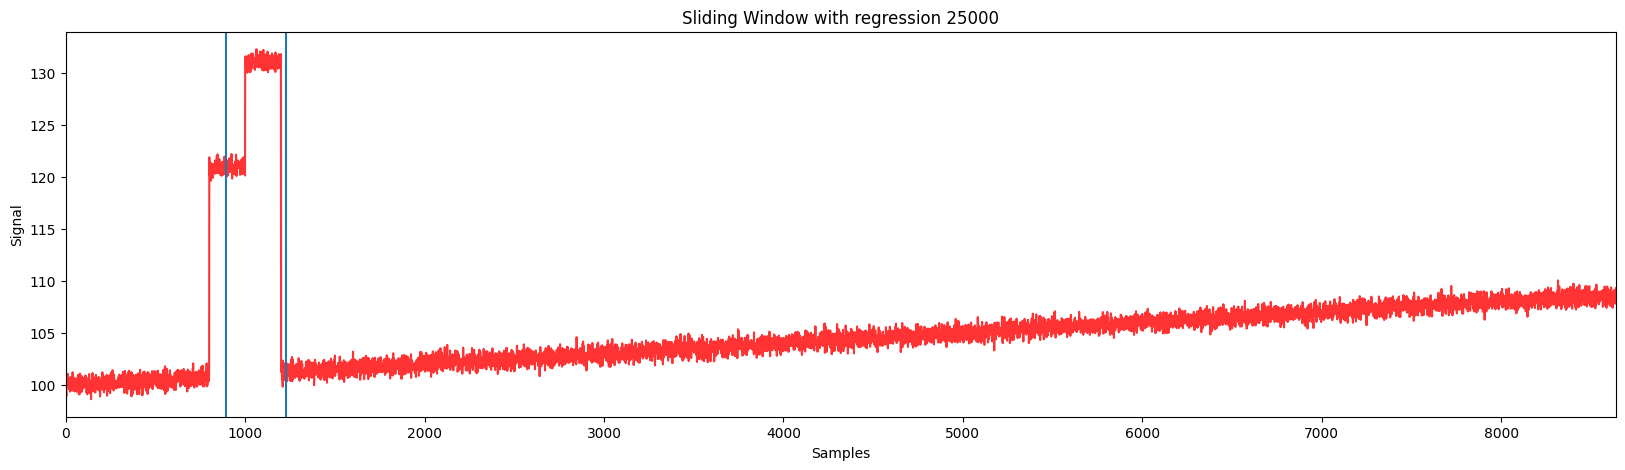

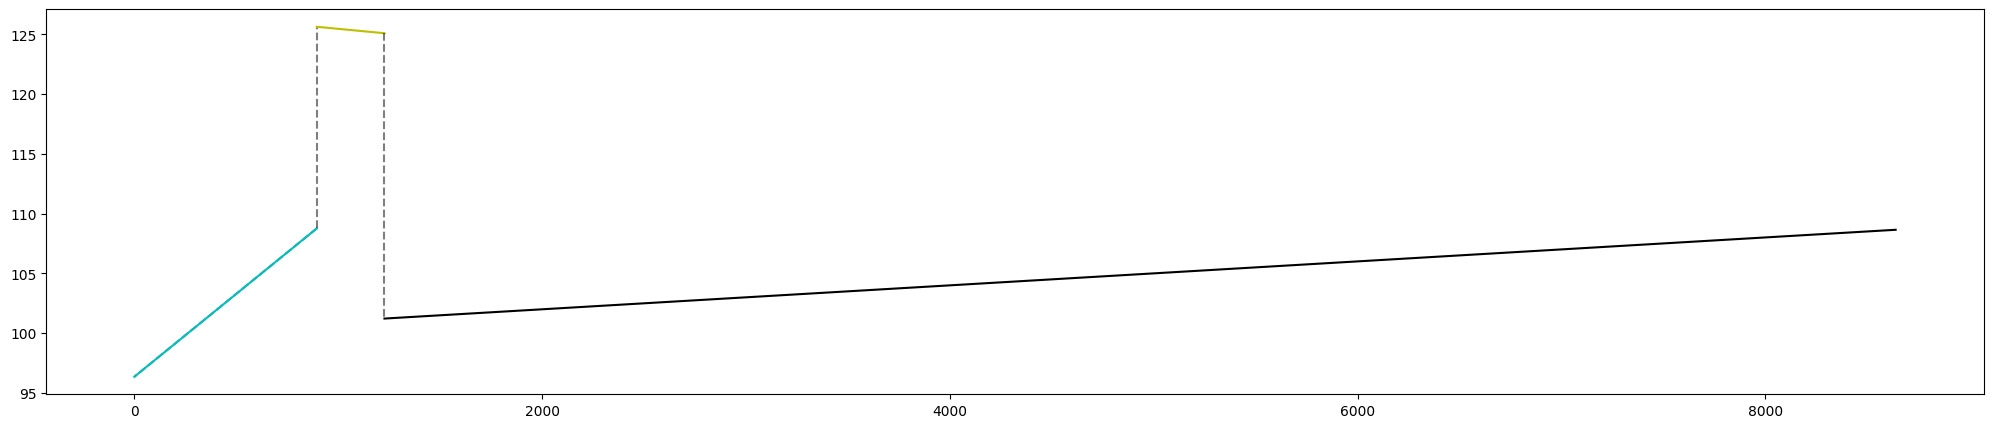

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.98588,0.918675,0.7625,0.833333


In [72]:
max_error = 25000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

## Best

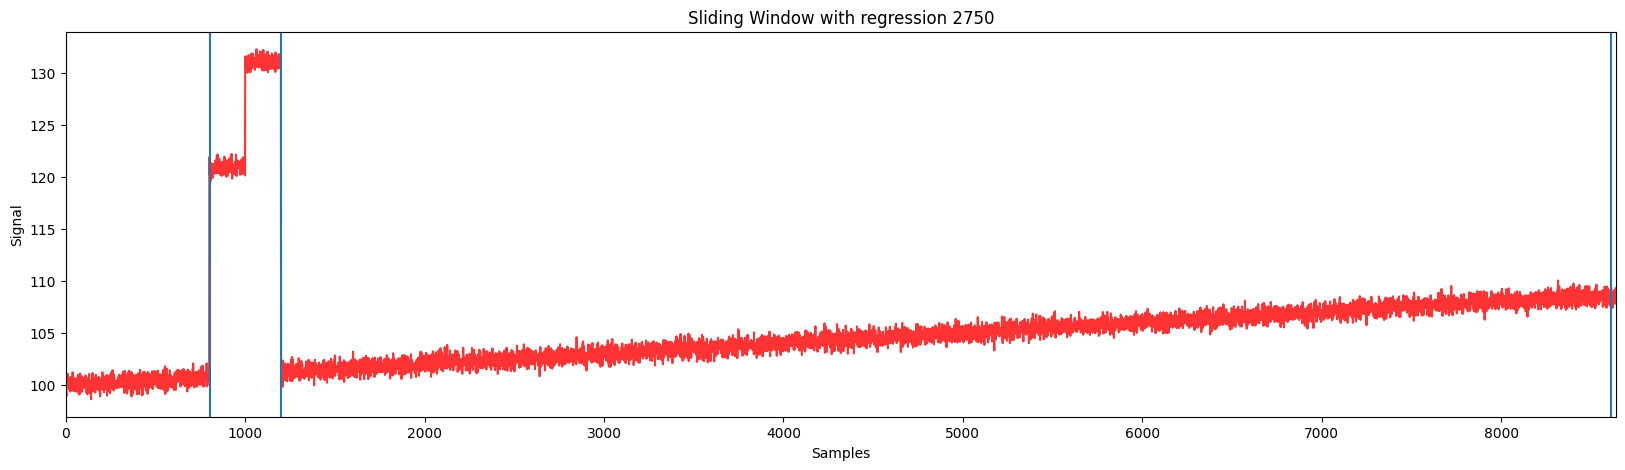

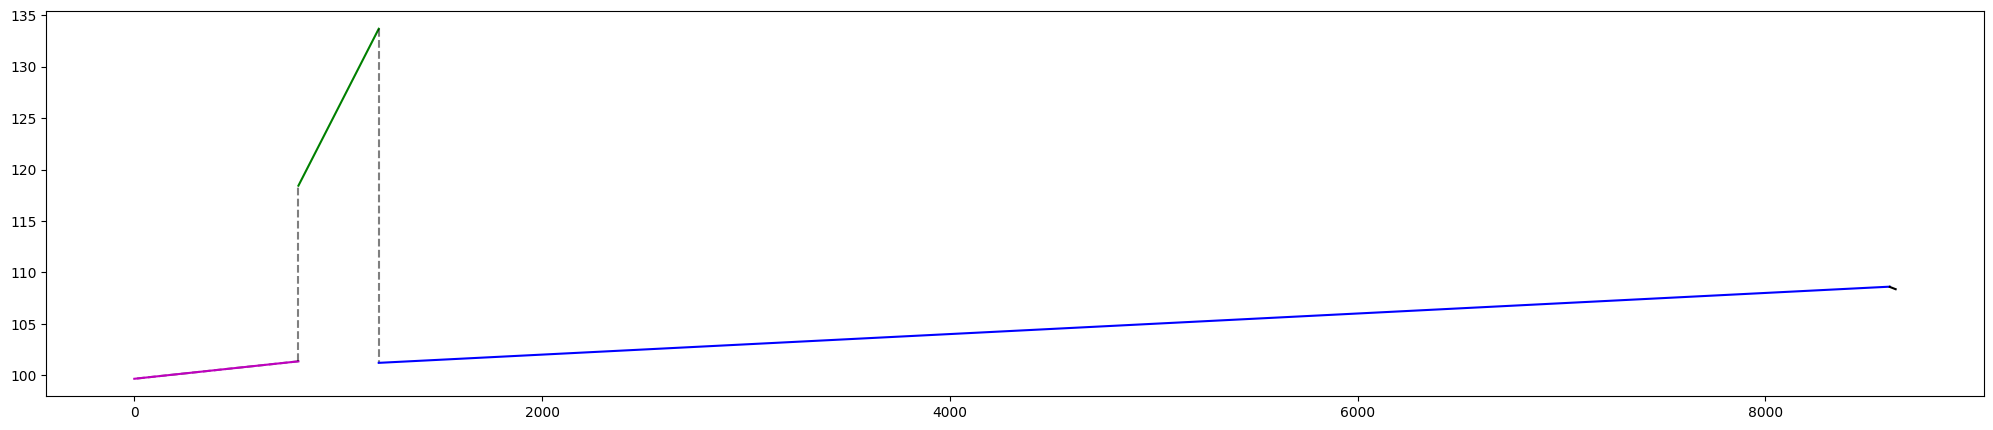

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999306,1.0,0.985,0.992443


In [93]:
max_error = 2750
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

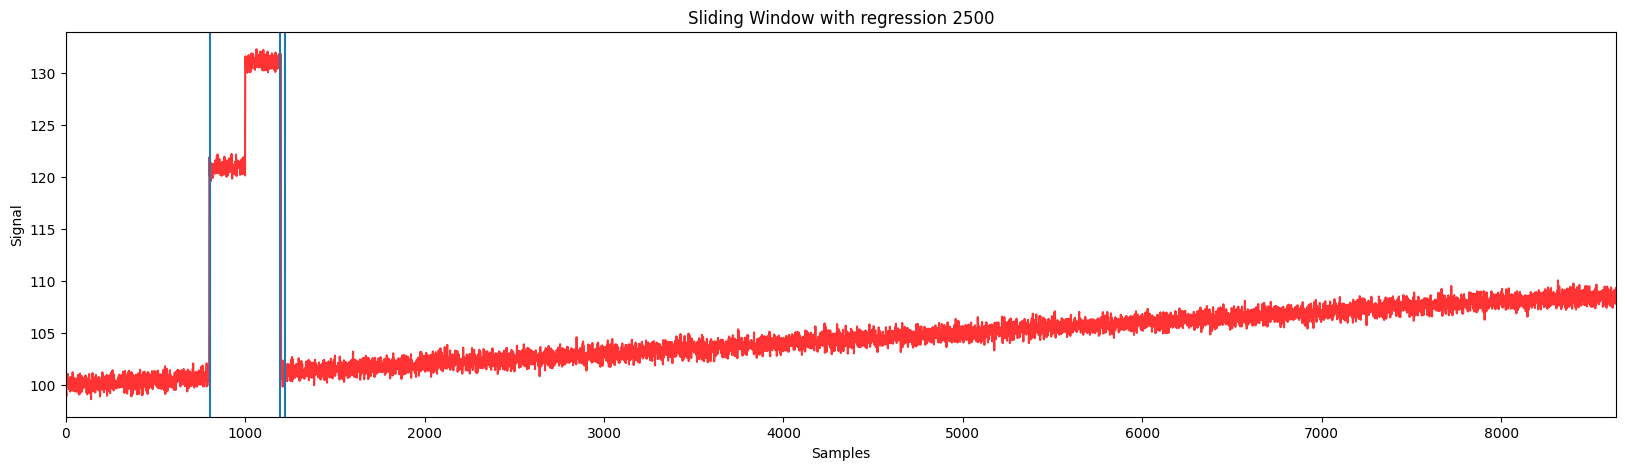

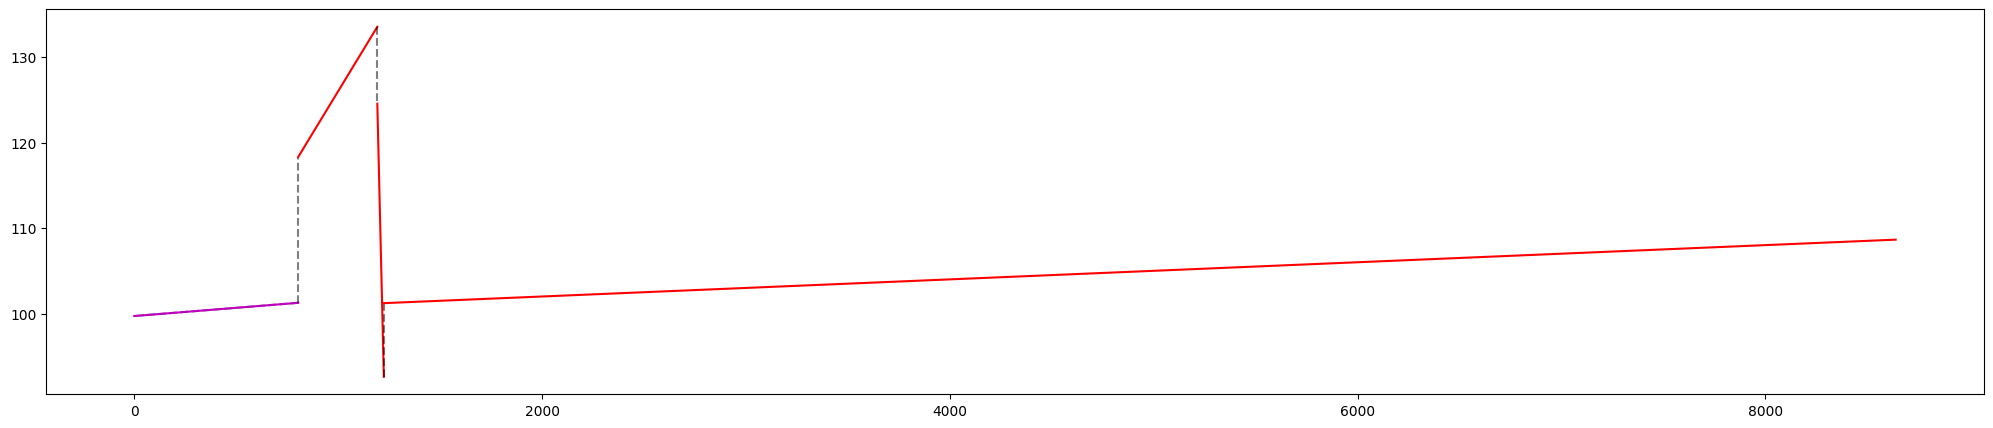

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.998611,1.0,0.97,0.984772


In [73]:
max_error = 2500
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [81]:
range_max_error_sldw = (2500,25000)
best_sliding_window = 2750
time_avg_sliding_window = (4.67+4.55+4.6)/3

# SWAB

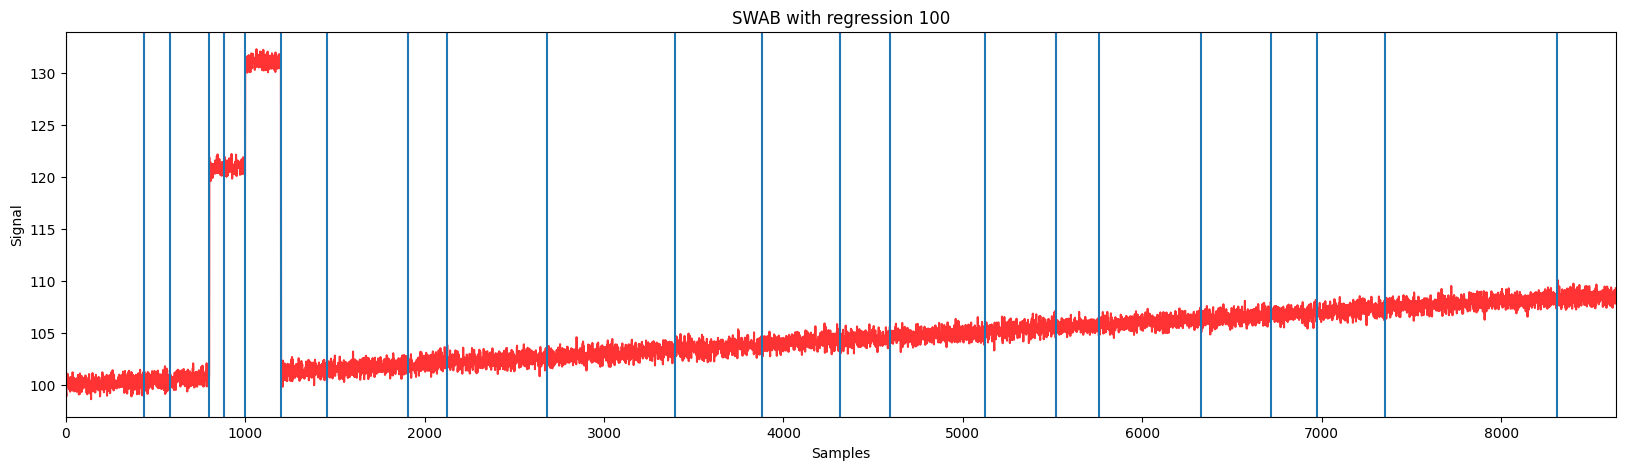

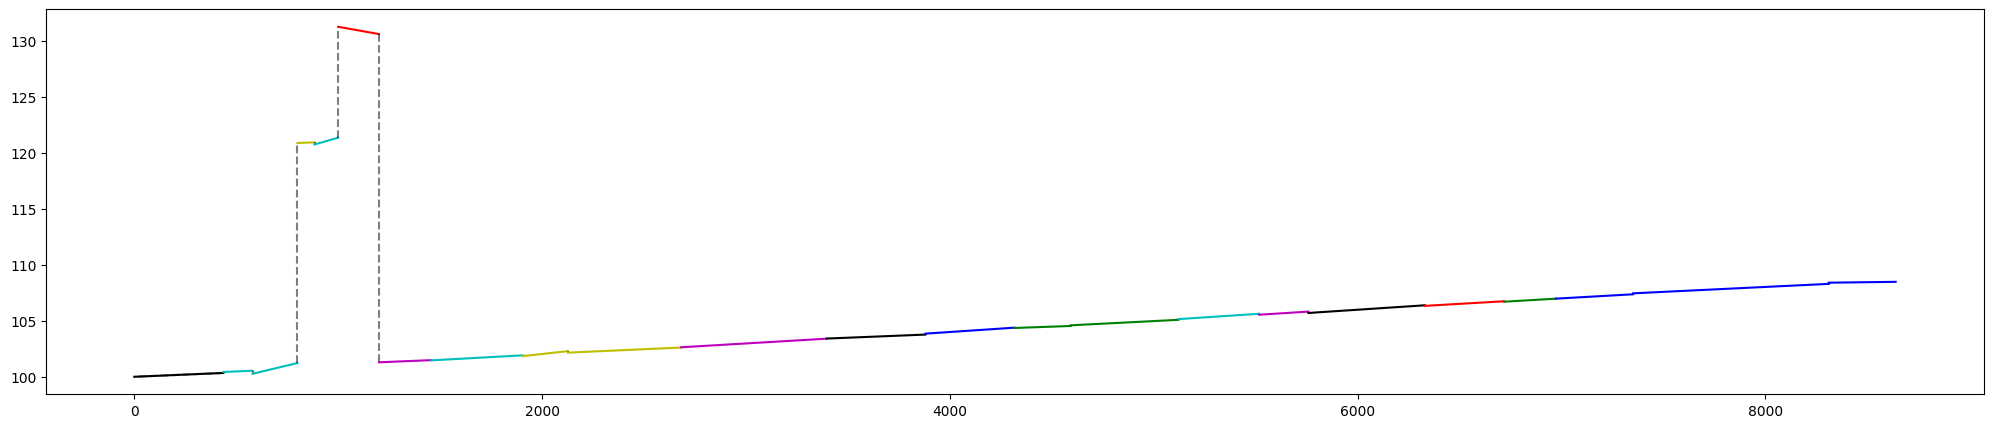

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.976852,1.0,0.5,0.666667


In [88]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

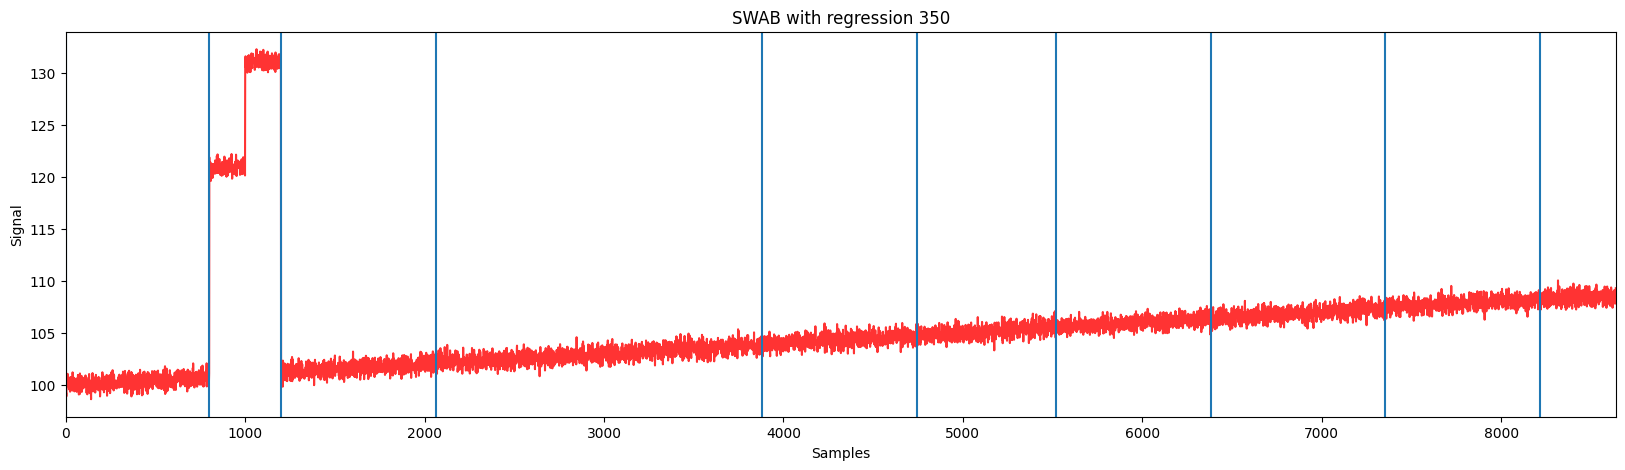

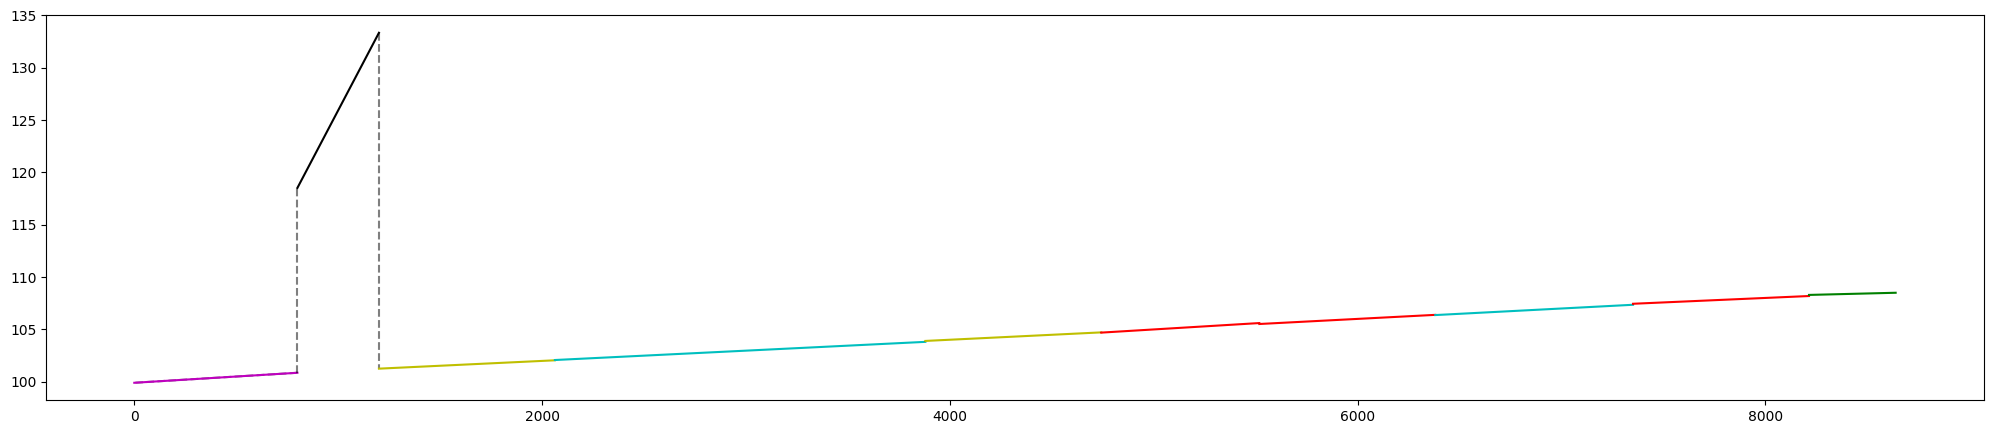

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [89]:
max_error = 350
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

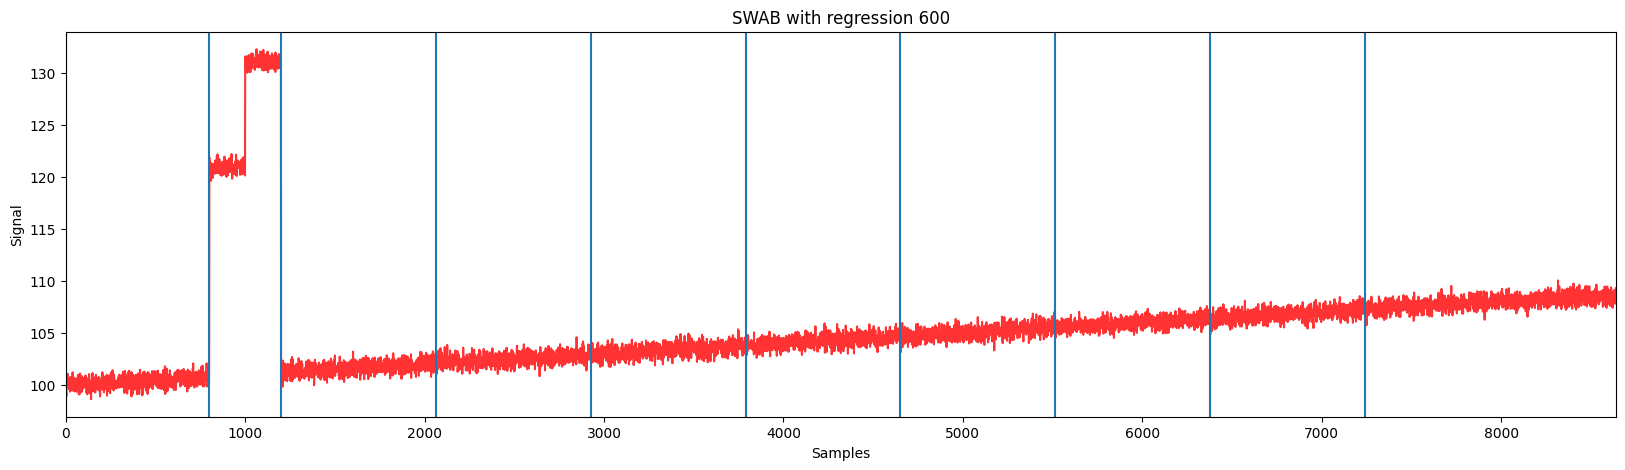

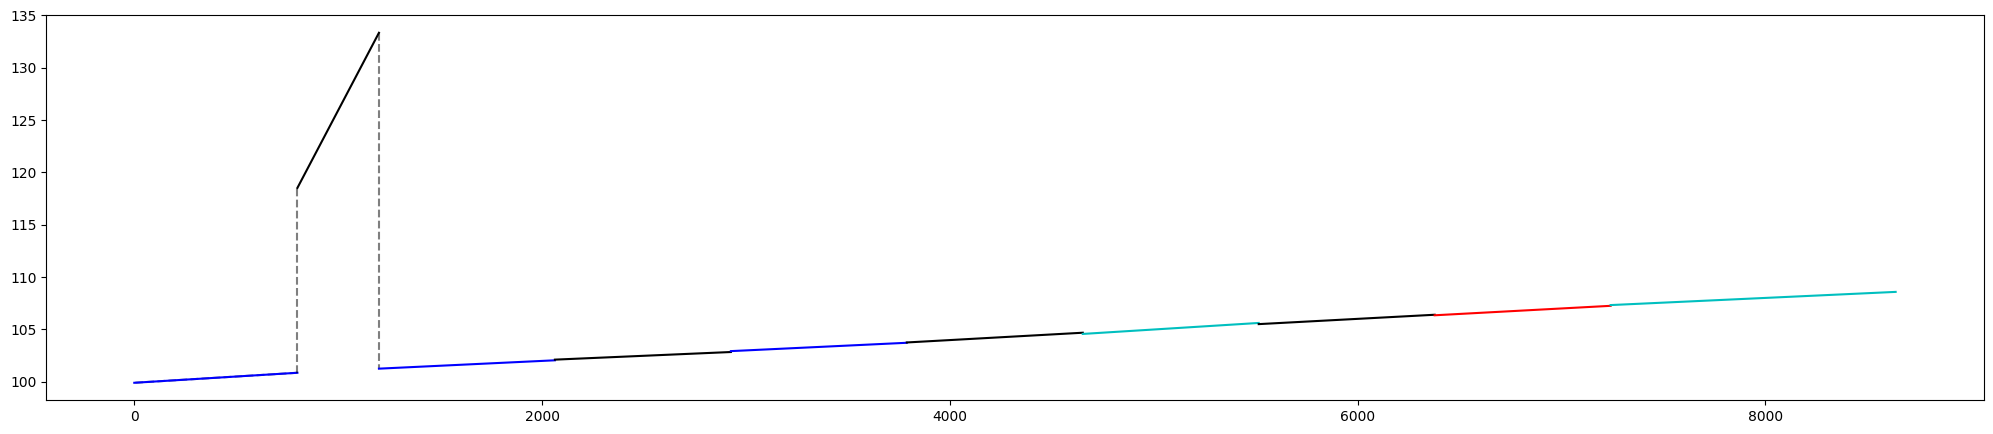

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [86]:
max_error = 600
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [91]:
range_max_error_swab = (100,600)
best_swab = 350
time_avg_swab = (5.87+6.58+16.5)/3

# Conclusion

In [96]:
data = {
    'Id' : [3,3,3,3],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min(max_error)': [range_max_error_topdown[0],range_max_error_bottomup[0], range_max_error_sldw[0],range_max_error_swab[0]],
    'max(max_error)': [range_max_error_topdown[1],range_max_error_bottomup[1],range_max_error_sldw[1],range_max_error_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(in range)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [2,1,3,1]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min(max_error),max(max_error),Best,Time Average(in range),Accuracy,Precision,Recall,F1-score,Rank
0,3,Top-down,4000,57500,29500,11.500000,0.999884,0.997506,1.000,0.998752,2
1,3,Bottom-up,100,625,350,5.303333,1.000000,1.000000,1.000,1.000000,1
2,3,Sliding-window,2500,25000,2750,4.606667,0.999306,1.000000,0.985,0.992443,3
3,3,SWAB,100,600,350,9.650000,1.000000,1.000000,1.000,1.000000,1


# To exp

## Conclusion

In [97]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

## Feature _ Maxerror

In [102]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 3
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_max_error_topdown[0]
feature_max_error['Max(max_error)_Top_down'] = range_max_error_topdown[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_max_error_bottomup[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_max_error_bottomup[1]
feature_max_error['Min(max_error)_SLDW'] = range_max_error_sldw[0]
feature_max_error['Max(max_error)_SLDW'] = range_max_error_sldw[1]
feature_max_error['Min(max_error)_SWAB'] = range_max_error_swab[0]
feature_max_error['Max(max_error)_SWAB'] = range_max_error_swab[1]
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = best_swab

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [133]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,absolute_sum_of_changes,mean_abs_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,2,8640,102.151881,100.286884,212.017664,14.560826,95822.993645,11.091908,4.776042,62.598994,181.709748,50000,350000,30000,90000,35000,150000,30000,90000,60000
1,1,8640,104.621483,100.014344,442.227086,21.029196,4986.149682,0.577167,16.640276,98.129950,201.585487,50,850000,50,10100,10000,550000,50,12500,4975
2,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
4,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
5,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
